<a href="https://colab.research.google.com/github/quanvu0996/TF_cert_training/blob/main/v2_2_ML20M_sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import psutil
# gives a single float value
print(psutil.cpu_percent())
# gives an object with many fields
print(psutil.virtual_memory())
# you can convert that object to a dictionary print(dict(psutil.virtual_memory()._asdict()))
# you can have the percentage of used RAM
print(psutil.virtual_memory().percent)
# you can calculate percentage of available memory
print(psutil.virtual_memory().available * 100 / psutil.virtual_memory().total)

20.2
svmem(total=13617745920, available=12827746304, percent=5.8, used=525139968, free=11176034304, active=968376320, inactive=1280540672, buffers=107241472, cached=1809330176, shared=1224704, slab=128778240)
5.8
94.19874903937112


In [91]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import gc

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split

In [3]:
tf.__version__

'2.8.0'

In [4]:
itemCol = 'movieId'
userCol = 'userId'

In [5]:
# DGX setup
# fpath = "./ml-20m" 

#colab setup
from google.colab import drive
drive.mount('/content/gdrive')
fpath = "/content/gdrive/MyDrive/RECOMMENDER_STUDIES/data/ml-20m"

Mounted at /content/gdrive


In [6]:
# Loading data
ratings = pd.read_csv(fpath+'/ratings.csv')

ratings

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580
...,...,...,...,...
20000258,138493,68954,4.5,1258126920
20000259,138493,69526,4.5,1259865108
20000260,138493,69644,3.0,1260209457
20000261,138493,70286,5.0,1258126944


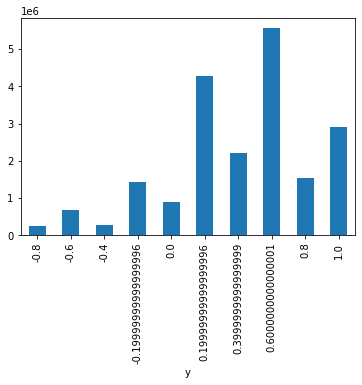

In [7]:
# Normalize rating về dạng -1 -> 1 (-1 = ghét, 1 = thích)
ratings["y"] = ratings["rating"]/2.5-1

# Kiểm tra rating trong khoảng -1 -> 1
ratings.groupby("y")["y"].count().plot(kind='bar')

# Model v2.2
Gộp tất cả các bước tiền xử lý vào model 

In [8]:
# Chia dữ liệu thành các tập cho model clustering, nhãn recommendation và test
#     warm_up_mask: ratings đã quan sát
#     target: rating dùng để đánh giá kết quả recommend của module recommend cho từng người dùng
#     test: đánh giá độc lập
# TODO: chia tập dữ liệu theo user-wise => đánh giá với những user hoàn toàn mới thì model có học được không?
# v2.1. gộp warm_up và mask thành 1
def dataset_split(ratings):
    train, test = train_test_split(ratings, test_size= 0.25)
    warm_up_mask, target = train_test_split(train, test_size= 0.25)
    return warm_up_mask, target, test

warm_up_mask, target, test = dataset_split(ratings)

In [9]:
# Kiểm tra số lượng ratings
warm_up_mask.shape[0], target.shape[0], test.shape[0]

(11250147, 3750050, 5000066)

In [12]:
# v2.2: chỉ groupby, không padding
def get_interaction_set(interaction, max_item = None, top_k_item = None):
    """
    Input:
        interaction: df[userCol, itemCol, y]: dữ liệu đầu vào
        max_item: int: item num limit
    Output:
        df, itemCol: list, y: list, itemCol_str: string, userCol as index
        list item sắp xếp theo giảm dần độ lớn rating
    """
    items = ratings.groupby(itemCol).count().sort_values(by=userCol, ascending=False)
    if top_k_item is not None:
        top_items = items.head(top_k_item).index
        interaction = interaction[interaction[itemCol].isin(top_items)]
    else:
        top_items = items.index

    # Sắp xếp item theo thứ tự giảm dần rating (về sau cắt padding sẽ ưu tiên giữ lại item có rating cao)
    rindex = interaction.groupby(userCol)["y"].transform(lambda grp: grp.sort_values(ascending=False).index)
    interaction = interaction.reindex(rindex)
    
    # Chuyển thành warm-up set theo từng user
    interaction = interaction.groupby("userId").agg({itemCol:list, "y":list})

    # Giới hạn độ dài warm_up size
    if max_item is not None:
        interaction[itemCol] = interaction[itemCol].apply(lambda x: x[0:max_item])
        interaction["y"] = interaction["y"].apply(lambda x: x[0:max_item])

    return interaction, top_items

top_k_item = 5000
wu_size = 150
mask_size = 50
max_item = wu_size + mask_size

interac_df, top_items = get_interaction_set(warm_up_mask[warm_up_mask[userCol]<10]
                    , max_item = max_item
                    , top_k_item = top_k_item )
interac_df

,movieId,y
userId,,
1,"[7153, 4754, 1333, 1036, 4911, 1215, 1358, 217...","[1.0, 0.6000000000000001, 0.6000000000000001, ..."
2,"[1270, 2948, 3928, 1327, 1748, 62, 541, 589, 2...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,"[2009, 260, 1084, 2968, 316, 2117, 1213, 858, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,"[733, 454, 377, 594, 489, 356, 368, 480, 596, ...","[1.0, 1.0, 0.6000000000000001, 0.6000000000000..."
5,"[1210, 595, 1097, 780, 318, 594, 260, 1198, 45...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
6,"[141, 52, 7, 17, 708, 260, 140, 494, 3, 135, 7...","[1.0, 1.0, 1.0, 1.0, 0.6000000000000001, 0.600..."
7,"[587, 4799, 1721, 1077, 4306, 750, 2028, 1256,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
8,"[296, 553, 527, 349, 648, 110, 356, 288, 597, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
9,"[4148, 1997, 1923, 2706, 356, 2841, 3979, 3857...","[1.0, 1.0, 0.6000000000000001, 0.6000000000000..."


### Xây dựng encoder model
Encoder =  interaction embedding + user feature embedding<br> 
interaction embedding = sum( interaction embedding các item i)<br> 
interaction embedding item i = rating x (embedding id sản phẩm + embedding item feature)<br>



In [25]:
%%time
# Vectorize (encode + padding) item list
max_vocab_size = len(top_items) # nếu số item có <= top_k_item => lấy số lượng item max
items_str = ' '.join([str(i) for i in top_items])
itemStr = itemCol+"_str"

vectorizer = layers.TextVectorization( max_tokens= top_k_item, split='whitespace', output_sequence_length= wu_size, name = 'vectorizer')
vectorizer.adapt( [items_str] ) 

CPU times: user 177 ms, sys: 4.34 ms, total: 182 ms
Wall time: 234 ms


In [27]:
class Broadcasting_Multiply(tf.keras.layers.Layer):
    """Nhân 2 layers khác shape với nhau, trong đó:
    inputs=[layer1, layer2]
    layer1.shape = (None, n_item, n_feature)
    layer2.shape = (None, n_item)
    (Chú ý đúng thứ tự)
    """

    def call(self, inputs):
        x, y = inputs

        #we add the extra dimension:
        y = K.expand_dims(y, axis=-1)
        #we replicate the elements
        y = K.repeat_elements(y, rep=x.shape[2], axis=-1)

        return x * y

In [203]:
# Xây dựng mạng
embedding_size = 200
reps_size = 150
cluster_num = 50

def interaction_embedding():

    input_wi = layers.Input(shape=(1,), name='input_wi')
    wi = vectorizer(input_wi)
    wi = layers.Embedding(input_dim= max_vocab_size, output_dim= embedding_size, mask_zero= True, name='ei')(wi)
    wi = layers.Dense(embedding_size, activation='linear', name='di')(wi)

    wr = layers.Input(shape=(wu_size,), name='warm_up_ratings')

    ireps = Broadcasting_Multiply(name='mul')([wi, wr])
    uprofile = layers.Lambda(lambda z: K.mean(z, axis=1), name='lambda')(ireps)

    # uprofile = layers.LayerNormalization(name='norm')(uprofile)
    uprofile = layers.Dense( reps_size, activation='linear', name='du')(uprofile)
    uprofile = layers.Dense(cluster_num, activation='sigmoid', name='clustering')(uprofile)
    
    model = tf.keras.Model(inputs= [input_wi, wr], outputs=[uprofile])
    return model

encode_model = interaction_embedding()

In [204]:
# Kiểm tra tham số
encode_model.summary()

Model: "model_50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_wi (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 vectorizer (TextVectorization)  (None, 150)         0           ['input_wi[0][0]']               
                                                                                                  
 ei (Embedding)                 (None, 150, 200)     1000000     ['vectorizer[16][0]']            
                                                                                                  
 di (Dense)                     (None, 150, 200)     40200       ['ei[0][0]']                     
                                                                                           

In [205]:
# tf.keras.utils.plot_model( encode_model ,show_shapes=True, show_dtype=True, show_layer_names=True )

### Ground truth
Nhận vào text (gồm các mã id sản phẩm) và ratings => chuyển thành vector theo từng user <br>
Dựng ground trust onehot bằng trung bình rating onehot

In [206]:
%%time
# Vectorize (encode + padding) item list
maskvec = layers.TextVectorization( max_tokens=max_vocab_size, split='whitespace', output_sequence_length= mask_size, name = 'maskvec')
maskvec.adapt( [items_str] ) 

CPU times: user 166 ms, sys: 1.29 ms, total: 167 ms
Wall time: 273 ms


In [207]:
# Xây dựng mạng
def eye_initializer(shape_list, dtype):
    return tf.eye(max_vocab_size)

def mask_label():

    input_mi = layers.Input(shape=(1,), name='input_mask')
    mi = maskvec(input_mi)
    mi = layers.Embedding(input_dim= max_vocab_size, output_dim= max_vocab_size, embeddings_initializer = eye_initializer, trainable=False)(mi)

    input_mr = layers.Input(shape=(mask_size,), name='mask_rating')

    ireps = Broadcasting_Multiply()([mi, input_mr])
    uprofile = layers.Lambda(lambda z: K.mean(z, axis=1), name='lambda')(ireps)
    
    model = tf.keras.Model(inputs= [input_mi, input_mr], outputs=[uprofile])
    return model

# Với bộ data không có user demographic thì ecoder = interaction_embedding, nếu có thì encoder = interaction_embedding concat user demo
dencode_model = mask_label()

In [208]:
# Kiểm tra số lượng tham số, đảm bảo layer embedding không có trainable param
dencode_model.summary()

Model: "model_51"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_mask (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 maskvec (TextVectorization)    (None, 50)           0           ['input_mask[0][0]']             
                                                                                                  
 embedding_17 (Embedding)       (None, 50, 5000)     25000000    ['maskvec[0][0]']                
                                                                                                  
 mask_rating (InputLayer)       [(None, 50)]         0           []                               
                                                                                           

### Mapping dims

In [209]:
# Mapping số chiều của clustering model với số chiều của label

def get_reps_model():

    input_reps = layers.Input(shape=(cluster_num), name='input_reps')
    reps = layers.Dense(max_vocab_size, activation='linear', name='representations')(input_reps)
    
    model = tf.keras.Model(inputs= [input_reps], outputs=[reps])
    return model

reps_model = get_reps_model()

In [210]:
# Check số lượng tham số 
reps_model.summary()

Model: "model_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_reps (InputLayer)     [(None, 50)]              0         
                                                                 
 representations (Dense)     (None, 5000)              255000    
                                                                 
Total params: 255,000
Trainable params: 255,000
Non-trainable params: 0
_________________________________________________________________


In [211]:
class Efficient_Rec(tf.keras.Model):
  def __init__(self, use_tf_function=False):
    super().__init__()
    self.use_tf_function = use_tf_function

    # Build the encoder and decoder
    encoder = interaction_embedding()
    reps = get_reps_model()
    decoder = mask_label()

    self.encoder = encoder
    self.decoder = decoder
    self.reps = reps

  def train_step(self, inputs):
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

In [212]:
def _wu_mask_split(self, batch_inputs, mask_ratio = 0.25):
    "Chia ratings và items thành mask, warm up"
    input_items, input_ratings = batch_inputs[itemCol], batch_inputs["y"]

    def list_split(input, mask_ratio = 0.25, seed= 42):
        return train_test_split(input[0:(wu_size+mask_size)], test_size= mask_ratio, random_state=seed)

    seed = random.randint(1, 100)
    items = input_items.apply(lambda x: list_split(x, mask_ratio, seed))
    ratings = input_ratings.apply(lambda x: list_split(x, mask_ratio, seed))

    wu_item_list = items.apply(lambda x: x[0])
    mask_item_list = items.apply(lambda x: x[1])

    wu_rating_list = ratings.apply(lambda x: x[0])
    mask_rating_list = ratings.apply(lambda x: x[1])
    return (wu_item_list, wu_rating_list), (mask_item_list, mask_rating_list)

Efficient_Rec._wu_mask_split = _wu_mask_split

In [213]:
def _preprocess(self, inputs, padding_size = 100):
    """
    Padding về wu_size và mask_size, convert list of items => string of items
    batch_inputs: df: itemStr, y"""

    def padding_list(list_item, wu_size, value=0, is_padding=True):
        series_item1 = list_item[0:wu_size]
        if is_padding:
            series_item1 = series_item1+[value]*(wu_size-len(series_item1))
        return series_item1

    items_list, ratings_list = inputs

    items   = items_list.apply(lambda x: ' '.join(list([str(i) for i in x])))
    ratings =   np.stack( ratings_list.apply(lambda x: padding_list( x, padding_size  ) ) )

    return items, ratings

Efficient_Rec._preprocess = _preprocess

In [214]:
def _train_step(self, inputs):
    warm_up, mask = self._wu_mask_split(inputs, mask_ratio = 0.25)
    wu_items, wu_ratings = self._preprocess(warm_up, wu_size)
    mask_item, mask_ratings = self._preprocess(mask, mask_size)

    with tf.GradientTape() as tape:
        # Encode the input
        wu_vec = self.encoder([wu_items, wu_ratings])
        y_pred = self.reps(wu_vec)

        # Encde the output
        mask_vec = self.decoder([mask_item, mask_ratings])

        average_loss = self.loss(mask_vec, y_pred)

    # Apply an optimization step
    variables = self.trainable_variables 
    gradients = tape.gradient(average_loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}

Efficient_Rec._train_step = _train_step

In [215]:
def Focus2(alpha=0.01):
    def cal_los(y_true, y_pred):
        y_pred = tf.cast(y_pred, tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        positive_true = y_true[y_true!=0]
        positive_pred = y_pred[y_true!=0]
        los1 = K.square(positive_true-positive_pred )

        zero_true = y_true[y_true==0]
        zero_pred = y_pred[y_true==0]
        los2 =alpha*  K.square(zero_true-zero_pred )


        return K.mean( tf.concat([los1, los2], axis=0) )
    return cal_los

y_true = tf.constant([1,0.2,0.1,1])
y_pred = tf.constant([1,0,5.2,1.005])

Focus2(0.01)(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=6.512506>

In [216]:
model = Efficient_Rec( use_tf_function=False)

# Configure the loss and optimizer
model.compile(
    optimizer=tf.optimizers.Adam(),
    loss=Focus2(0.01),
)

In [217]:
%%time
epochs= 20
for n in range(epochs):
  print(model.train_step( interac_df ))


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.288099e-05>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.9591526e-05>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.4422046e-05>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.911774e-05>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.860709e-05>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.343156e-05>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8709004e-05>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.556408e-05>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1895663e-05>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.8250011e-05>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.467936e-05>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.1494847e-05>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.8851833e-05>}
{'batch_loss': <tf.Tensor: shape=(), dtype=f

In [218]:
group_scores = model.encoder(model._preprocess( [interac_df[itemCol], interac_df["y"]], padding_size = wu_size )).numpy()
group_scores

array([[0.49424624, 0.49517715, 0.49681607, 0.49541914, 0.4968728 ,
        0.49386948, 0.49440965, 0.49638954, 0.49439588, 0.49513155,
        0.49748498, 0.49442384, 0.49640253, 0.49585846, 0.49432957,
        0.49748683, 0.493343  , 0.49545687, 0.4937054 , 0.49496284,
        0.49669296, 0.4933155 , 0.4970155 , 0.49341688, 0.49465272,
        0.4954883 , 0.49296415, 0.49941015, 0.49105972, 0.4987171 ,
        0.49621257, 0.4950787 , 0.49418673, 0.49249515, 0.4942093 ,
        0.49427626, 0.49922147, 0.4953669 , 0.49801156, 0.4951162 ,
        0.49505854, 0.49748242, 0.50044334, 0.49388298, 0.49352184,
        0.49478933, 0.49381617, 0.49259618, 0.4943981 , 0.4953564 ],
       [0.49477336, 0.4950468 , 0.4974224 , 0.4959008 , 0.49723512,
        0.4942787 , 0.49442428, 0.49650297, 0.49402365, 0.49550998,
        0.49677947, 0.49431044, 0.49733287, 0.49638614, 0.49464643,
        0.4970438 , 0.49415332, 0.49564824, 0.49345332, 0.49554703,
        0.49717414, 0.4935593 , 0.49732122, 0.4

0.02 0.0 0.000120000004


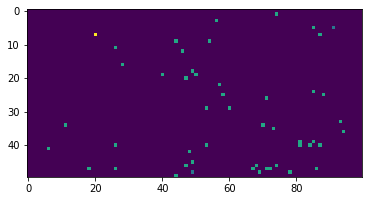

0.02 -0.004 6.96e-05


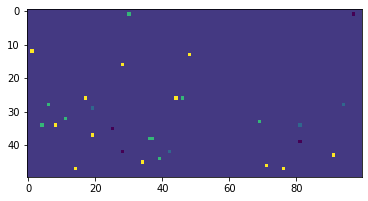

0.02 0.0 0.00018239999


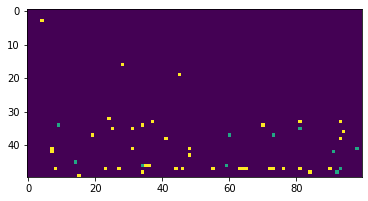

0.02 0.0 2.96e-05


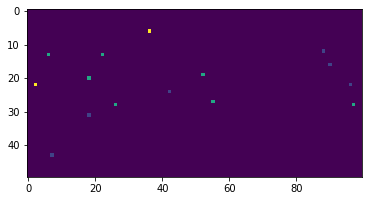

0.02 -0.004 0.000114400005


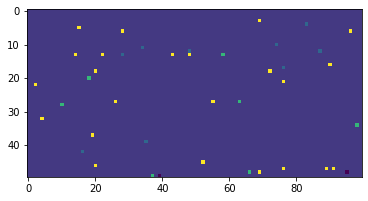

0.02 0.0 2.96e-05


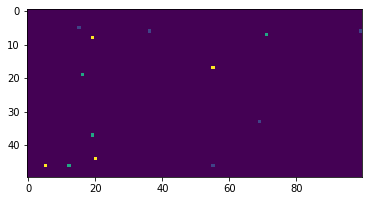

0.02 0.0 0.0001344


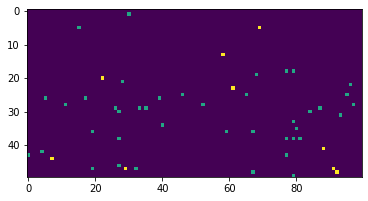

0.024 -0.004 9.28e-05


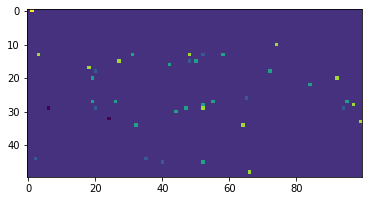

0.02 -0.012 1.5199999e-05


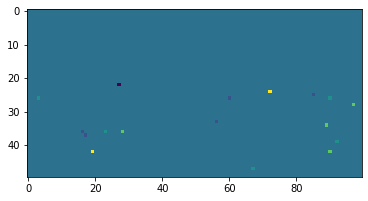

In [219]:
y_true = model.decoder(model._preprocess( [interac_df[itemCol], interac_df["y"]], padding_size = mask_size )).numpy()
for i in range(y_true.shape[0]):
    y_true_i = y_true[i].reshape((50,100))
    print( np.max(y_true_i), np.min(y_true_i), np.mean(y_true_i)  )
    plt.imshow( y_true_i)
    plt.show()

In [220]:
# for i in range(group_scores.shape[0]):
#     plt.imshow( group_scores[i].numpy().reshape((5,10)) )
#     plt.show()

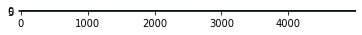

In [221]:
plt.imshow(y_true)

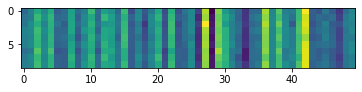

In [222]:
plt.imshow(group_scores)

In [223]:
gc.collect()

21169